### Question:

The training data is pulled from raw logs. It has three columns that record user activity over time:
user_id: A hash that uniquely identifies the user.
activity_date: The date of the activity
activity_type: The type of activity

6sense would like to predict which users will purchase given the user's activities. 

Using the training data, build a model that predicts which user_id's will make a purchase in the future. Use the model to score the test data from most likely to least likely to purchase.

Please submit the following:
- (1) Describe which activity types you believe are most useful in predicting which user will purchase in the future.
- (2) Provide a file (csv, tsv, or similar) containing the 1000 user_id's most likely to convert.
- (3) Any work used to generate the list and/or notes you'd like to include.




#### Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score,roc_curve,auc, accuracy_score, confusion_matrix, classification_report,log_loss, f1_score, average_precision_score
from sklearn.model_selection import train_test_split,GridSearchCV, KFold, cross_val_score, train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import time
import traceback

#### Import Train Dataset

In [2]:
df=pd.read_csv('training.tsv',sep='\t',header=0)
df.columns=['user_id','activity_date','activity_type']
df.head()

,user_id,activity_date,activity_type
0,00002acbe042d69,2013-07-11,FormSubmit
1,00002acbe042d69,2013-07-15,EmailOpen
2,00002acbe042d69,2013-07-17,EmailOpen
3,00002acbe042d69,2013-07-18,EmailOpen
4,00002acbe042d69,2013-07-25,EmailOpen


#### Import Test Dataset

In [3]:
test=pd.read_csv('test.tsv',sep='\t')
test.columns=['user_id','activity_date','activity_type']
test.head()

,user_id,activity_date,activity_type
0,0000ecf58c94668,2015-06-11,EmailOpen
1,0000ecf58c94668,2015-06-29,EmailOpen
2,0000ecf58c94668,2015-07-05,EmailOpen
3,0000ecf58c94668,2015-07-29,EmailOpen
4,000132f21724ee2,2015-05-15,EmailClickthrough


In [4]:
df.info() #There is not NaN value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4918676 entries, 0 to 4918675
Data columns (total 3 columns):
user_id          object
activity_date    object
activity_type    object
dtypes: object(3)
memory usage: 112.6+ MB


### Exploratory Data Analysis

For understanding the data better I start with some EDA

In [5]:
df.activity_type.value_counts()

EmailOpen            3191731
Purchase              395031
WebVisit              384025
PageView              382263
EmailClickthrough     285568
FormSubmit            176067
CustomerSupport       103991
Name: activity_type, dtype: int64

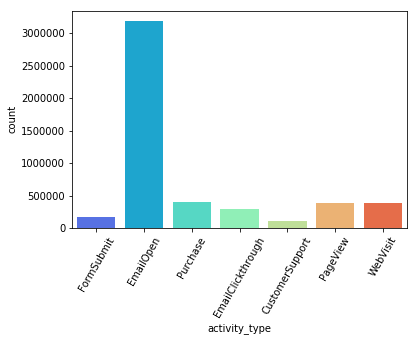

In [6]:
sns.countplot(x="activity_type", data=df,palette='rainbow')
plt.xticks(rotation=60)
plt.show()

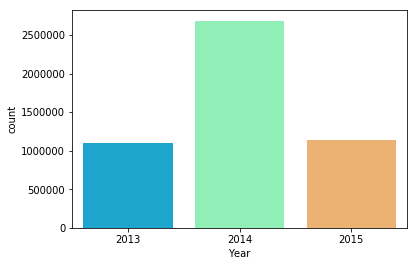

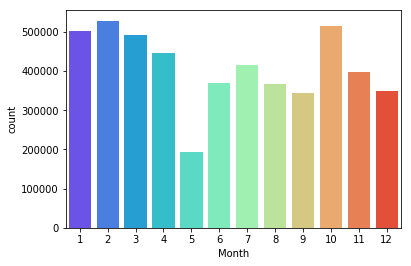

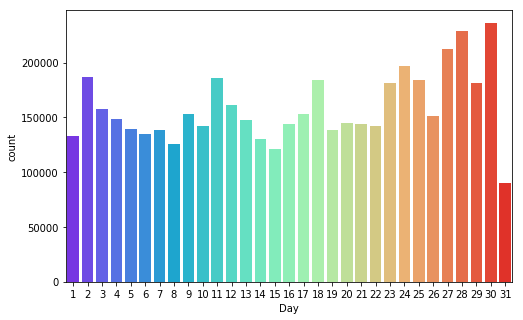

In [7]:
df['activity_date']=pd.to_datetime(df['activity_date'])

sns.countplot(df['activity_date'].dt.year,palette='rainbow')
plt.xlabel('Year')
plt.show()
sns.countplot(df['activity_date'].dt.month,palette='rainbow')
plt.xlabel('Month')
plt.show()
plt.figure(figsize=(8,5))
sns.countplot(df['activity_date'].dt.day,palette='rainbow')
plt.xlabel('Day')
plt.show()

#### Create a data frame where each user_id has its total activity base on the type

In [8]:
df1=pd.pivot_table(df.groupby(by=['user_id','activity_type']).count(),index='user_id',columns='activity_type',values='activity_date',fill_value=0)
df1.head()

activity_type,CustomerSupport,EmailClickthrough,EmailOpen,FormSubmit,PageView,Purchase,WebVisit
user_id,,,,,,,
00002acbe042d69,0,0,8,1,0,0,0
0000a3a34bd07e6,0,0,20,0,0,0,0
0000ecf58c94668,1,1,11,1,0,6,0
00012205dd4613b,0,0,2,0,0,0,0
000198d39a568cf,1,0,0,0,0,1,0


#### Create a new column to show if the user_id had a purchase or not

In [9]:
df1['HadPurchase']=[*map(lambda x:x*1, df1['Purchase']>0)]
df1.head()

activity_type,CustomerSupport,EmailClickthrough,EmailOpen,FormSubmit,PageView,Purchase,WebVisit,HadPurchase
user_id,,,,,,,,
00002acbe042d69,0,0,8,1,0,0,0,0
0000a3a34bd07e6,0,0,20,0,0,0,0,0
0000ecf58c94668,1,1,11,1,0,6,0,1
00012205dd4613b,0,0,2,0,0,0,0,0
000198d39a568cf,1,0,0,0,0,1,0,1


#### Check correlation among columns

In [10]:
df1.corr()

activity_type,CustomerSupport,EmailClickthrough,EmailOpen,FormSubmit,PageView,Purchase,WebVisit,HadPurchase
activity_type,,,,,,,,
CustomerSupport,1.000000,0.069687,0.069879,0.059705,0.088687,0.353339,0.088519,1.000000
EmailClickthrough,0.069687,1.000000,0.674694,0.783081,0.595017,0.369027,0.595523,0.069687
EmailOpen,0.069879,0.674694,1.000000,0.591831,0.503523,0.402415,0.503988,0.069879
FormSubmit,0.059705,0.783081,0.591831,1.000000,0.557026,0.379792,0.559712,0.059705
PageView,0.088687,0.595017,0.503523,0.557026,1.000000,0.309214,0.999877,0.088687
Purchase,0.353339,0.369027,0.402415,0.379792,0.309214,1.000000,0.309547,0.353339
WebVisit,0.088519,0.595523,0.503988,0.559712,0.999877,0.309547,1.000000,0.088519
HadPurchase,1.000000,0.069687,0.069879,0.059705,0.088687,0.353339,0.088519,1.000000


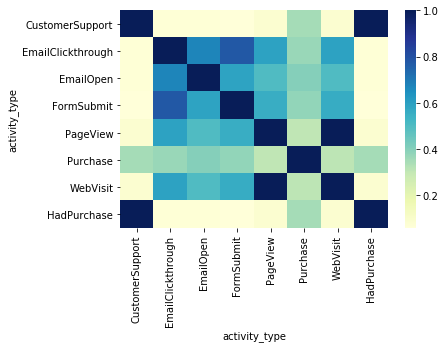

In [11]:
sns.heatmap(df1.corr(),cmap="YlGnBu")
plt.show()

#### 'CustomerSupport' and 'HadPurchase' are same. So this column has to remove for future predition.
So it means customer support is for user_ids who had at least one purchase.
#### 'WebVisit' and 'PageView' have very hight correlation. I remove 'WebVisit' from the the dataset.

In [12]:
del df1['CustomerSupport']
del df1['WebVisit']

### Solve the Classification problem
So the 'HadPurchase' columns is the target value.

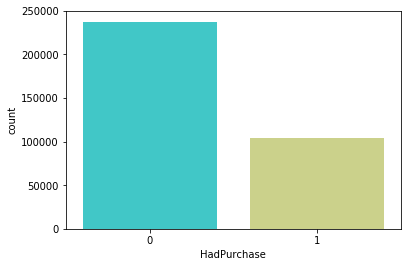

In [13]:
sns.countplot(df1['HadPurchase'],palette='rainbow')
plt.show()

In [14]:
df1['HadPurchase'].value_counts()

0    237577
1    103991
Name: HadPurchase, dtype: int64

In [15]:
len(df1[df1['HadPurchase']==1])/len(df1)*100

30.445182218474798

#### More than 30% of the user_ids had at least one purchase.

#### Define train/test split for picking the best classifier

In [16]:
X = df1[['EmailClickthrough','EmailOpen','FormSubmit','PageView']]
y = df1['HadPurchase']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#### Picked classifiers are:
- Logistic Regression
- Random Forest
- Gradient Boosting
- LightGBM

In [17]:
models1=[]
models1.append(('Logistic Regression', LogisticRegression(random_state=42)))
models1.append(('Random Forest', RandomForestClassifier(random_state=42)))
models1.append(('Gradient Boosting', GradientBoostingClassifier(random_state=42)))
models1.append(('LightGBM',lgb.LGBMClassifier(random_state=42)))

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

names = []
scores_test = []
scores_train = []
AUC1=[]
Log_loss=[]
F1_Score=[]
Time=[]
AUC=[]
for name, model in tqdm(models1):
    start=time.time()
    #Fitting the model
    model.fit(X_train, y_train)
    end=time.time()
    #Training time
    Time.append(end-start)
    y_pred = model.predict(X_test)
    y_pred_prob=model.predict_proba(X_test)[:, 1]
    scores_test.append(accuracy_score(y_test, y_pred))
    scores_train.append(accuracy_score(y_train, model.predict(X_train)))
    AUC1.append(roc_auc_score(y_test, y_pred_prob))
    AUC.append(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    names.append(name)
    #F1_Score
    F1_Score.append(f1_score(y_test, y_pred))#, average=None)  
Result1 = pd.DataFrame({'Name': names, 
                        'ROC_AUC_Train':AUC,'ROC_AUC_Test':AUC1,'F1_score':F1_Score,'Execution_Time':Time})
Result1

100%|██████████| 4/4 [00:38<00:00,  8.94s/it]


,Name,ROC_AUC_Train,ROC_AUC_Test,F1_score,Execution_Time
0,Logistic Regression,0.283023,0.279770,0.045377,0.598655
1,Random Forest,0.907676,0.886820,0.786525,2.190745
2,Gradient Boosting,0.896639,0.896887,0.794451,22.094392
3,LightGBM,0.898665,0.898495,0.794443,3.661304


#### LightGBM is the fastest with the highest F1-score and AUC. I pick LGB to train the model with the whole train dataset. The model may improve by hyper tuning by grid search or random search. AlsoThe data is imbalance, so maybe undersampling or oversampling with SMOTE improve the performance. However, due to the time limit, I stick with what I have got so far.  



In [18]:
model=lgb.LGBMClassifier(random_state=42)
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### Feature Importance

In [19]:
X=X_train.append(X_test)
y=y_train.append(y_test)
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

# Find feature importances
features = pd.Series(clf.feature_importances_, index=X_train.columns)
# Find feature importances
feature_importance = pd.DataFrame(clf.feature_importances_).T
feature_importance.columns = list(X_train.columns)
feature_importance = feature_importance.T
feature_importance.columns = ['feature_importance']
feature_importance.sort_values('feature_importance', ascending=False)

,feature_importance
EmailOpen,0.644950
FormSubmit,0.211754
EmailClickthrough,0.092204
PageView,0.051093


#### The most important feature is the 'EmailOpen'. So this feature has an important role in predicting if the user will purchase in future or not.
#### The second most important feature is the 'FormSubmit'.

### Testing

In [20]:
test.head()

,user_id,activity_date,activity_type
0,0000ecf58c94668,2015-06-11,EmailOpen
1,0000ecf58c94668,2015-06-29,EmailOpen
2,0000ecf58c94668,2015-07-05,EmailOpen
3,0000ecf58c94668,2015-07-29,EmailOpen
4,000132f21724ee2,2015-05-15,EmailClickthrough


In [21]:
test1=pd.pivot_table(test.groupby(by=['user_id','activity_type']).count(),index='user_id',columns='activity_type',values='activity_date',fill_value=0)
test1.head()

activity_type,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit
user_id,,,,,
0000ecf58c94668,0,4,0,0,0
000132f21724ee2,1,1,0,0,0
0001b315b991cf0,0,3,0,0,0
000269150971d08,0,4,0,0,0
000297ba4fa5026,0,3,0,0,0


In [22]:
test1.corr()

activity_type,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit
activity_type,,,,,
EmailClickthrough,1.000000,0.585482,0.692476,0.709560,0.708623
EmailOpen,0.585482,1.000000,0.443457,0.521143,0.519350
FormSubmit,0.692476,0.443457,1.000000,0.623081,0.645458
PageView,0.709560,0.521143,0.623081,1.000000,0.997029
WebVisit,0.708623,0.519350,0.645458,0.997029,1.000000


In [23]:
del test1['WebVisit']

#### Sort the user_ids base on the output probability

In [24]:
y_pred = model.predict(test1)
y_pred_prob=model.predict_proba(test1)[:, 1]
test1['y_test_prob']=y_pred_prob
Final=test1.sort_values(by='y_test_prob',ascending=False)['y_test_prob'].head(1000)
Final.head()

user_id
2c2c4af11b62946    0.999593
d6a142cf06f209a    0.999593
7c21520dc24c16f    0.916548
904a3da97a91f9b    0.887008
921dabe84d0c995    0.884402
Name: y_test_prob, dtype: float64

In [25]:
Final.to_csv('Final.csv',  header=True)

#### Answers:

- (1) Describe which activity types you believe are most useful in predicting which user will purchase in the future.

#### The most important feature is the 'EmailOpen'. So this feature has an important role in predicting if the user will purchase in future or not.The second most important feature is the 'FormSubmit'.
- (2) Provide a file (csv, tsv, or similar) containing the 1000 user_id's most likely to convert.

#### Please find the Final.csv file attached.
- (3) Any work used to generate the list and/or notes you'd like to include.

#### This ipython is my work.